In [1]:
import mne
from mne.preprocessing import ICA
from mne.decoding import CSP
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

<h1 style="color: red; font-weight: bold;">Preprocessing</h1>

## 1.) Loading data

In [2]:
def load_data(subject, session="T"):
    """
    Loads data, includes all channels including EEG and EOG.
    Args:
        subject (int): number of the subject
        session (str):T for training, E for evaluation
    returns: 
        raw (RawGDF): an mne object containing the raw data
        data_raw (list(list(float))): list containing each channel and corresponding data, channel x data samples 
        times (list): list containing each channel and corresponding times, channel x time samples
    """
    
    file_path = f"data/bca_4_2a/A0{subject}{session}.gdf"
    raw = mne.io.read_raw_gdf(file_path, preload=True, eog=["EOG-left", "EOG-central", "EOG-right"], verbose=0)
    data_raw, times = raw.get_data(return_times=True)
    raw.rename_channels({'EEG-Fz': 'EEG-Fz','EEG-0': 'EEG-2','EEG-1': 'EEG-3','EEG-2': 'EEG-4','EEG-3': 'EEG-5','EEG-4': 'EEG-6','EEG-5': 'EEG-7','EEG-C3': 'EEG-C3','EEG-6': 'EEG-9','EEG-Cz': 'EEG-Cz','EEG-7': 'EEG-11','EEG-C4': 'EEG-C4','EEG-8': 'EEG-13','EEG-9': 'EEG-14','EEG-10': 'EEG-15','EEG-11': 'EEG-16','EEG-12': 'EEG-17','EEG-13': 'EEG-18','EEG-14': 'EEG-19','EEG-Pz': 'EEG-Pz','EEG-15': 'EEG-21','EEG-16': 'EEG-22','EOG-left': 'EOG-left','EOG-central': 'EOG-central','EOG-right': 'EOG-right'})

    return raw, data_raw, times

In [3]:
# test subject 1
sub1_raw, sub1_data_raw, sub1_times = load_data(1)

c:\Users\jacob\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


## 2.) Filter data

In [4]:
def bandpass_filter(raw_data, bands):
    """
    Creates bandpass filters for raw data
    Args:
        raw_data (list(list(floats))): raw data from a single subject
        bands (list(tuples)): bands which need to be created
    Returns:
        filtered_data (list(RawGDF)): returns a list of RawGDF objects, each with their specified bandpass filter
    """

    filtered_data = []
    for band in bands:
        filtered_data.append(raw_data.filter(l_freq=band[0], h_freq=band[1], verbose=0))
        
    return filtered_data

In [5]:
# a list of RawGDF objects, each with thier own bandpass filter
sub1_filtered_list = bandpass_filter(sub1_raw,[(0,5),(5,40)])

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


## 3.) Artifact Detection and Removal (if needed)

### Manual Artifact Detection and Removal

In [6]:
def detect_artifact(raw_data, artifact):
    """
    Produces a number of plots to check if the current dataframe has major artifacts
    Args:
        raw_data (RawGDF): RawGDF object
        artifact (string): 'low freq drift'. 'power line noise', 'heartbeat', 'ocular'
    Returns:
        Plot based on specified artifact
    """
    data = raw_data.copy()
    if artifact == "low freq drift":
        return data.plot(duration=60, remove_dc=False, verbose=0) #direct current offset set to False
    elif artifact == "power line noise":
        return data.plot_psd(fmax=100, verbose=0) #
    elif artifact == "eog":
        eog_epochs = mne.preprocessing.create_eog_epochs(data, baseline=(-0.5, -0.2)) #finds eog artifacts and extracts into an Epoch object in one step
        eog_epochs.plot_image(combine="mean")
        # eog_epochs.average().plot_joint()

Using EOG channels: EOG-left, EOG-central, EOG-right
EOG channel index for this subject is: [22 23 24]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG-central for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 16 significant peaks
Number of EOG events detected: 16
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 16 events and 251 original time points ...

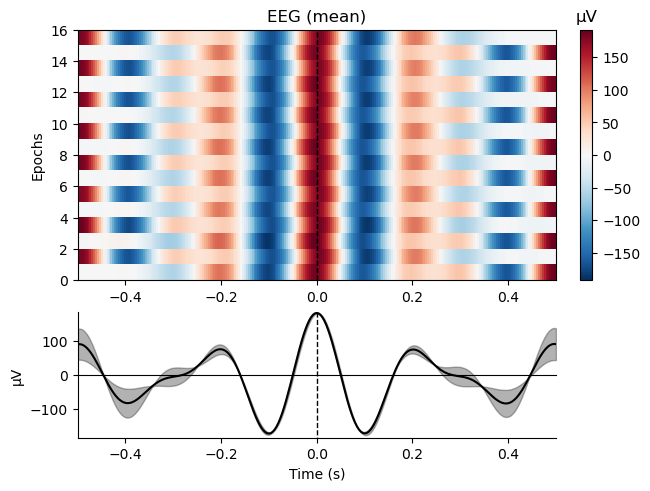

In [7]:
detect_artifact(sub1_filtered_list[1], "eog")

### Automatic Artifact Detection and Removal

In [8]:
def do_ICA(filtered_data, n_components, remove):
    data = filtered_data.copy()
    ica = ICA(n_components=n_components, random_state=97, method="fastica")
    ica.fit(data)
    ecg_idx, ecg_scores = ica.find_bads_ecg(data)
    return ecg_idx, ecg_scores

    # # Automatically detect eye-blink artifacts using EOG channels
    # eog_indices, eog_scores = ica.find_bads_eog(raw)
    # # Plot correlation with EOG signals
    # ica.plot_scores(eog_scores)
    # # Remove detected components
    # if remove:
    #     ica.exclude = eog_indices
    #     # Apply ICA cleaning to EEG data
    #     raw_cleaned = ica.apply(raw)
    #     return raw_cleaned

## 4.) Epoching

In [9]:
def create_epoch(filtered_data, min, max):
    """
    Creating epochs from filtered and artifact clean data
    Args:
        filtered_data (RawGDF): gdf object
    Returns:
        epochs (epoch): mne epoch object for this subject and filter
    """

    events = mne.events_from_annotations(filtered_data, verbose=0)

    event_dict = {"rejected trial":1,"eye movements":2,"idling eeg (eyes open)":3,"idling eeg (eyes closed)":4,"new run":5,"start trial":6,"left":7,"right":8,"feet":9,"tongue":10}
    
    epochs = mne.Epochs(
        filtered_data.copy(), # raw filtered data
        events[0], # event array
        tmin=min, # time before event, baseline correction (seconds)
        tmax=max, # time after event (seconds)
        event_repeated="drop", # what to do when multiple events have the same starting time
        preload=True, # preload data into memory for faster processing
        event_id=event_dict, # mapping event id to the actual event description
        verbose=0
        )
    
    return epochs

In [10]:
sub1_epochs_list = [create_epoch(i, -0.5, 2) for i in sub1_filtered_list]

<h1 style="color: red; font-weight: bold;">Classification</h1>

# 5.) Feature Extraction

In [11]:
def do_CSP(epoch_data, n_components, labels):
    """
    Extracts spatial features from epoched trails from specified classes. Features are also standardized.
    Args:
        epoch_data (epoch): mne epoch object
    Returns:
        dataset (list(list(int))): dataset as a np array with the last entry in each list as the label

    """
    d = epoch_data.copy()

    epoch_list = []
    for label in labels:
        epoch_list.append(d[label])
    data = mne.concatenate_epochs(epoch_list, verbose=0)

    X = data.pick("eeg").get_data()
    y = data.events[:,-1]

    csp = CSP(n_components=n_components)
    X_csp = csp.fit_transform(X, y)

    dataset = np.hstack((X_csp, y.reshape(-1,1)))
    return dataset


In [12]:
sub1lr_dataset = do_CSP(sub1_epochs_list[1], 6, ["left", "right"])

Computing rank from data with rank=None


C:\Users\jacob\AppData\Local\Temp\ipykernel_15596\2721646757.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  data = mne.concatenate_epochs(epoch_list, verbose=0)


    Using tolerance 1.5e-05 (2.2e-16 eps * 22 dim * 3e+09  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.


# 6.) Creating Training, Validation, and Test Datasets

In [13]:
# normal train, val, test
def create_tvt_datasets(dataset, trainr, valtestr):
    """
    Creating test, validation, and test datasets for classification
    Args:
        epoch_data (epoch): epoch object of a single subject
        trainr, valtestr (float): ratio of splits
        label (list(str)): name of the class we are interested in for this dataset, "left", "right", "feet", "toungue"
    """

    data = dataset.copy()

    # Get the number of epochs
    n_epochs = len(data)
    
    # Generate shuffled indices
    indices = np.arange(n_epochs)
    np.random.seed(42)
    np.random.shuffle(indices)

    # Compute split points
    train_end = int(n_epochs * trainr)
    val_end = train_end + int(n_epochs * valtestr)

    # Split indices
    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    # Create subsets
    epochs_train = data[train_indices]
    epochs_val = data[val_indices]
    epochs_test = data[test_indices]

    return epochs_train, epochs_val, epochs_test

In [14]:
sub1lr_train, sub1lr_val, sub1lr_test = create_tvt_datasets(sub1lr_dataset, 0.7, 0.15)

# 7.) Classify

In [14]:
def LDA_fit(train_data):
    X_train = train_data[:,:-1]
    y_train = train_data[:,-1]

    # Scale data for LDA
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    # Initialize and train LDA classifier
    lda = LinearDiscriminantAnalysis()
    return lda.fit(X_train_scaled, y_train), scaler


In [15]:
sub1_fitted_model, sub1_scaler = LDA_fit(sub1lr_train)

In [16]:
def LDA_predict(model, X, scaler=None):
    """
    Takes in a model and 
    """
    X_test = X[:,:-1]

    # scale X test data from a fitted train scaler
    X_test_scaled = scaler.transform(X_test)

    # Predict the labels for test data
    y_pred = model.predict(X_test_scaled)

    return y_pred

In [17]:
sub1_preds = LDA_predict(sub1_fitted_model, sub1lr_test, sub1_scaler)

In [18]:
accuracy = accuracy_score(sub1_preds, sub1lr_test[:,-1])

In [19]:
accuracy

0.8695652173913043

<h1 style="color: red; font-weight: bold;">Classification</h1>

In [20]:
def cross_subject_classification_pipeline(bsub, tsubs, lf, hf, emin, emax, csp_comp,):
    """
    Complete cross subject classification and evaluation
    Args:
        subject_base (int): baseline subject for model to be trained on
        subject_test (list(ints)): list of subjects to test base model against
        lf (int): lower frequency to filter raw data
        hf (int): high frequency to filter raw data
        emin (int/float): time in seconds before cue, for baseline correction
        emax (int/float): time in seconds after cue
        csp_comp (int): number of csp components to extract

    """
    # base subject load data
    bsub_raw, bsub_data_raw, bsub_times = load_data(bsub)

    # base subject filter data
    bsub_filtered = bandpass_filter(bsub_raw,[(lf,hf)])

    # base subject epoch data
    bsub_epoch = create_epoch(bsub_filtered[0], emin, emax)

    # base subject feature extraction 
    bsub_dataset = do_CSP(bsub_epoch, csp_comp, ["left", "right"])

    # base subject create train val, test sets
    bsub_train, bsublr_val, bsub_test = create_tvt_datasets(bsub_dataset, 0.7, 0.15)

    # base subject fit LDA model
    bsub_model, bsub_scaler, = LDA_fit(bsub_train)

    # base subject LDA model predictions
    bsub_preds = LDA_predict(bsub_model, bsub_train, bsub_scaler)

    results = []

    # base subject prediction on its own train test split
    bsub_train_y = bsub_train[:,-1]
    bsub_bsub_accuracy = accuracy_score(bsub_train_y, bsub_preds)

    results.append(f"bsub->bsub: {bsub_bsub_accuracy}")

    for tsub in tsubs:
        print(f"start: {tsub}")
        tsub_raw, _, _ = load_data(tsub)

        # test subject filter data
        tsub_filtered = bandpass_filter(tsub_raw,[(lf,hf)])

        # test subject epoch data
        tsub_epoch = create_epoch(tsub_filtered[0], emin, emax)

        # test subject feature extraction 
        tsub_dataset = do_CSP(tsub_epoch, csp_comp, ["left", "right"])

        # using the base subject model on the whole test subject dataset
        tsub_preds = LDA_predict(bsub_model, tsub_dataset, bsub_scaler)
        tsub_dataset_y = tsub_dataset[:,-1]
        
        results.append(f"bsub->sub{tsub}:{accuracy_score(tsub_dataset_y, tsub_preds)}")
        print(f"end: {tsub}")
    return results

In [21]:
cross_subject_classification_pipeline(
    bsub=2,
    tsubs=[1,3,5,6,7,8,9],
    lf=4,
    hf=50,
    emin=-1,
    emax=4,
    csp_comp=6
)

c:\Users\jacob\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


KeyboardInterrupt: 

# Formatting Data for RL

In [ ]:
def format_for_jacob(bsub):

    # base subject load data
    bsub_raw, _, _ = load_data(bsub)

    # base subject filter data
    bsub_filtered = bandpass_filter(bsub_raw,[(8,30)])

    # base subject epoch data
    bsub_epoch = create_epoch(bsub_filtered[0], 0.5, 2.5)

    # base subject feature extraction 
    bsub_dataset = do_CSP(bsub_epoch, 6, ["left", "right"])

    return [bsub_dataset[:,:-1], bsub_dataset[:,-1]]


In [16]:
X_data = []
y = []
for subject in [1,2,3,5,6,7,8,9]:
    X_data.append(format_for_jacob(subject)[0])
    y.append(format_for_jacob(subject)[1])

c:\Users\jacob\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Computing rank from data with rank=None


C:\Users\jacob\AppData\Local\Temp\ipykernel_15596\2721646757.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  data = mne.concatenate_epochs(epoch_list, verbose=0)


    Using tolerance 6.5e-05 (2.2e-16 eps * 22 dim * 1.3e+10  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.


c:\Users\jacob\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
C:\Users\jacob\AppData\Local\Temp\ipykernel_15596\2721646757.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  data = mne.concatenate_epochs(epoch_list, verbose=0)


Computing rank from data with rank=None
    Using tolerance 6.5e-05 (2.2e-16 eps * 22 dim * 1.3e+10  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.


c:\Users\jacob\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
C:\Users\jacob\AppData\Local\Temp\ipykernel_15596\2721646757.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  data = mne.concatenate_epochs(epoch_list, verbose=0)


Computing rank from data with rank=None
    Using tolerance 6.8e-05 (2.2e-16 eps * 22 dim * 1.4e+10  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.


c:\Users\jacob\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
C:\Users\jacob\AppData\Local\Temp\ipykernel_15596\2721646757.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  data = mne.concatenate_epochs(epoch_list, verbose=0)


Computing rank from data with rank=None
    Using tolerance 6.8e-05 (2.2e-16 eps * 22 dim * 1.4e+10  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.


c:\Users\jacob\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Computing rank from data with rank=None


C:\Users\jacob\AppData\Local\Temp\ipykernel_15596\2721646757.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  data = mne.concatenate_epochs(epoch_list, verbose=0)


    Using tolerance 8.2e-05 (2.2e-16 eps * 22 dim * 1.7e+10  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.


c:\Users\jacob\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Computing rank from data with rank=None


C:\Users\jacob\AppData\Local\Temp\ipykernel_15596\2721646757.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  data = mne.concatenate_epochs(epoch_list, verbose=0)


    Using tolerance 8.2e-05 (2.2e-16 eps * 22 dim * 1.7e+10  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.


c:\Users\jacob\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s
C:\Users\jacob\AppData\Local\Temp\ipykernel_15596\2721646757.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  data = mne.concatenate_epochs(epoch_list, verbose=0)


Computing rank from data with rank=None
    Using tolerance 5.8e-05 (2.2e-16 eps * 22 dim * 1.2e+10  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.


c:\Users\jacob\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
C:\Users\jacob\AppData\Local\Temp\ipykernel_15596\2721646757.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  data = mne.concatenate_epochs(epoch_list, verbose=0)


Computing rank from data with rank=None
    Using tolerance 5.8e-05 (2.2e-16 eps * 22 dim * 1.2e+10  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.


c:\Users\jacob\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
C:\Users\jacob\AppData\Local\Temp\ipykernel_15596\2721646757.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  data = mne.concatenate_epochs(epoch_list, verbose=0)


Computing rank from data with rank=None
    Using tolerance 9.2e-05 (2.2e-16 eps * 22 dim * 1.9e+10  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.


c:\Users\jacob\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
C:\Users\jacob\AppData\Local\Temp\ipykernel_15596\2721646757.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  data = mne.concatenate_epochs(epoch_list, verbose=0)


Computing rank from data with rank=None
    Using tolerance 9.2e-05 (2.2e-16 eps * 22 dim * 1.9e+10  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.


c:\Users\jacob\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Computing rank from data with rank=None


C:\Users\jacob\AppData\Local\Temp\ipykernel_15596\2721646757.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  data = mne.concatenate_epochs(epoch_list, verbose=0)


    Using tolerance 5.9e-05 (2.2e-16 eps * 22 dim * 1.2e+10  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.


c:\Users\jacob\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Computing rank from data with rank=None


C:\Users\jacob\AppData\Local\Temp\ipykernel_15596\2721646757.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  data = mne.concatenate_epochs(epoch_list, verbose=0)


    Using tolerance 5.9e-05 (2.2e-16 eps * 22 dim * 1.2e+10  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.


c:\Users\jacob\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
C:\Users\jacob\AppData\Local\Temp\ipykernel_15596\2721646757.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  data = mne.concatenate_epochs(epoch_list, verbose=0)


Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 22 dim * 2.1e+10  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.


c:\Users\jacob\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Computing rank from data with rank=None


C:\Users\jacob\AppData\Local\Temp\ipykernel_15596\2721646757.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  data = mne.concatenate_epochs(epoch_list, verbose=0)


    Using tolerance 0.0001 (2.2e-16 eps * 22 dim * 2.1e+10  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.


c:\Users\jacob\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s
C:\Users\jacob\AppData\Local\Temp\ipykernel_15596\2721646757.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  data = mne.concatenate_epochs(epoch_list, verbose=0)


Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 22 dim * 2.1e+10  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.


c:\Users\jacob\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
C:\Users\jacob\AppData\Local\Temp\ipykernel_15596\2721646757.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  data = mne.concatenate_epochs(epoch_list, verbose=0)


Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 22 dim * 2.1e+10  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.


In [17]:
clf = LinearDiscriminantAnalysis()

In [18]:
from eeg_env_agent_test import EEGFeatureEnv

env = EEGFeatureEnv(X_train=X_data[0], y_train=y[0],other_subjects_X=X_data[1:], other_subjects_y=y[1:], classifier=clf)

In [19]:
from stable_baselines3 import PPO
from eeg_env_agent_test import EEGFeatureEnv

In [20]:
import random
num_list = [0,1,2,3,4,5,6,7]

training_folds = []

def get_folds(num_list): 

        copy = num_list.copy()
        
        train_list = random.sample(copy, 5)  # Select 5 random elements for training
        test_list = [num for num in copy if num not in train_list]  # Remaining 3 for testing
        
        training_folds.append((list(train_list), test_list))

get_folds(num_list)
get_folds(num_list)
get_folds(num_list)
print(training_folds)



[([6, 2, 4, 7, 1], [0, 3, 5]), ([2, 3, 6, 5, 7], [0, 1, 4]), ([2, 0, 5, 1, 6], [3, 4, 7])]


In [21]:
from tqdm import tqdm

In [22]:
#should be 15
best_features_list = []
total_iterations = sum(len(train_ind) for train_ind, _ in training_folds)

with tqdm(total=total_iterations, desc="Processing folds") as pbar:
    for train_ind, test_ind in training_folds:

        for i, main_sub in enumerate(train_ind):

            X_train = X_data[main_sub]
            y_train = y[main_sub]

            other_subjects_X = [X_data[idx] for idx in train_ind if idx != main_sub]
            other_subjects_y = [y[idx] for idx in train_ind if idx != main_sub]

            clf = LinearDiscriminantAnalysis()

            env = EEGFeatureEnv(X_train=X_train, 
                                y_train=y_train,
                                other_subjects_X=other_subjects_X,
                                other_subjects_y=other_subjects_y, 
                                classifier=clf)

            model = PPO('MlpPolicy', env, 
                        learning_rate=1e-4, 
                        gamma=0.995,
                        gae_lambda=0.9,
                        batch_size=256,
                        clip_range=0.1,
                        verbose=1)
            model.learn(total_timesteps=20000)

            best_transformed_features = np.array([v[0] for v in env.best_features.values()])

            best_features_list.append(best_transformed_features)

            pbar.update(1)


Processing folds:   0%|          | 0/15 [00:00<?, ?it/s]

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\jacob\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 720      |
|    ep_rew_mean     | -7.6e+04 |
| time/              |          |
|    fps             | 112      |
|    iterations      | 1        |
|    time_elapsed    | 18       |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 720          |
|    ep_rew_mean          | -7.33e+04    |
| time/                   |              |
|    fps                  | 99           |
|    iterations           | 2            |
|    time_elapsed         | 41           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 6.654492e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.1          |
|    entropy_loss         | -2.84        |
|    explained_variance   | -4.78e-05    |
|    learning_r

Processing folds:   7%|▋         | 1/15 [06:29<1:30:53, 389.51s/it]c:\Users\jacob\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 720       |
|    ep_rew_mean     | -7.23e+04 |
| time/              |           |
|    fps             | 51        |
|    iterations      | 1         |
|    time_elapsed    | 39        |
|    total_timesteps | 2048      |
----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 720           |
|    ep_rew_mean          | -7.26e+04     |
| time/                   |               |
|    fps                  | 50            |
|    iterations           | 2             |
|    time_elapsed         | 81            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00010099789 |
|    clip_fraction        | 0             |
|    clip_range           | 

Processing folds:  13%|█▎        | 2/15 [12:21<1:19:37, 367.50s/it]c:\Users\jacob\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 720       |
|    ep_rew_mean     | -7.68e+04 |
| time/              |           |
|    fps             | 64        |
|    iterations      | 1         |
|    time_elapsed    | 31        |
|    total_timesteps | 2048      |
----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 720           |
|    ep_rew_mean          | -7.32e+04     |
| time/                   |               |
|    fps                  | 75            |
|    iterations           | 2             |
|    time_elapsed         | 54            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 4.6110305e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 

Processing folds:  20%|██        | 3/15 [16:31<1:02:47, 314.00s/it]c:\Users\jacob\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 720       |
|    ep_rew_mean     | -6.66e+04 |
| time/              |           |
|    fps             | 71        |
|    iterations      | 1         |
|    time_elapsed    | 28        |
|    total_timesteps | 2048      |
----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 720           |
|    ep_rew_mean          | -6.97e+04     |
| time/                   |               |
|    fps                  | 72            |
|    iterations           | 2             |
|    time_elapsed         | 56            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00010827283 |
|    clip_fraction        | 0             |
|    clip_range           | 

Processing folds:  27%|██▋       | 4/15 [21:11<55:06, 300.57s/it]  c:\Users\jacob\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 720       |
|    ep_rew_mean     | -7.27e+04 |
| time/              |           |
|    fps             | 71        |
|    iterations      | 1         |
|    time_elapsed    | 28        |
|    total_timesteps | 2048      |
----------------------------------
--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 720            |
|    ep_rew_mean          | -6.96e+04      |
| time/                   |                |
|    fps                  | 83             |
|    iterations           | 2              |
|    time_elapsed         | 49             |
|    total_timesteps      | 4096           |
| train/                  |                |
|    approx_kl            | 0.000118182594 |
|    clip_fraction        | 0              |
|    clip_range 

Processing folds:  33%|███▎      | 5/15 [25:30<47:35, 285.52s/it]c:\Users\jacob\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 720       |
|    ep_rew_mean     | -7.15e+04 |
| time/              |           |
|    fps             | 96        |
|    iterations      | 1         |
|    time_elapsed    | 21        |
|    total_timesteps | 2048      |
----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 720           |
|    ep_rew_mean          | -7.08e+04     |
| time/                   |               |
|    fps                  | 89            |
|    iterations           | 2             |
|    time_elapsed         | 45            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 4.9893657e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 

Processing folds:  40%|████      | 6/15 [29:41<41:04, 273.85s/it]c:\Users\jacob\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 720       |
|    ep_rew_mean     | -7.17e+04 |
| time/              |           |
|    fps             | 84        |
|    iterations      | 1         |
|    time_elapsed    | 24        |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 720          |
|    ep_rew_mean          | -7.18e+04    |
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 2            |
|    time_elapsed         | 49           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 7.232255e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.1         

Processing folds:  47%|████▋     | 7/15 [34:16<36:33, 274.14s/it]c:\Users\jacob\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 720       |
|    ep_rew_mean     | -7.43e+04 |
| time/              |           |
|    fps             | 61        |
|    iterations      | 1         |
|    time_elapsed    | 33        |
|    total_timesteps | 2048      |
----------------------------------
--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 720            |
|    ep_rew_mean          | -7.2e+04       |
| time/                   |                |
|    fps                  | 58             |
|    iterations           | 2              |
|    time_elapsed         | 69             |
|    total_timesteps      | 4096           |
| train/                  |                |
|    approx_kl            | 0.000115564064 |
|    clip_fraction        | 9.77e-05       |
|    clip_range 

Processing folds:  53%|█████▎    | 8/15 [39:45<34:00, 291.46s/it]c:\Users\jacob\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 720       |
|    ep_rew_mean     | -7.44e+04 |
| time/              |           |
|    fps             | 81        |
|    iterations      | 1         |
|    time_elapsed    | 25        |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 720          |
|    ep_rew_mean          | -7.25e+04    |
| time/                   |              |
|    fps                  | 79           |
|    iterations           | 2            |
|    time_elapsed         | 51           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 6.724545e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.1         

Processing folds:  60%|██████    | 9/15 [44:01<28:03, 280.59s/it]c:\Users\jacob\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 720      |
|    ep_rew_mean     | -7.2e+04 |
| time/              |          |
|    fps             | 76       |
|    iterations      | 1        |
|    time_elapsed    | 26       |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 720           |
|    ep_rew_mean          | -7.11e+04     |
| time/                   |               |
|    fps                  | 75            |
|    iterations           | 2             |
|    time_elapsed         | 54            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00015091556 |
|    clip_fraction        | 0             |
|    clip_range           | 0.1       

Processing folds:  67%|██████▋   | 10/15 [48:28<23:01, 276.39s/it]c:\Users\jacob\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 720       |
|    ep_rew_mean     | -7.55e+04 |
| time/              |           |
|    fps             | 78        |
|    iterations      | 1         |
|    time_elapsed    | 26        |
|    total_timesteps | 2048      |
----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 720           |
|    ep_rew_mean          | -7.31e+04     |
| time/                   |               |
|    fps                  | 76            |
|    iterations           | 2             |
|    time_elapsed         | 53            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 5.9299666e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 

Processing folds:  73%|███████▎  | 11/15 [52:37<17:51, 267.86s/it]c:\Users\jacob\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 720       |
|    ep_rew_mean     | -7.06e+04 |
| time/              |           |
|    fps             | 135       |
|    iterations      | 1         |
|    time_elapsed    | 15        |
|    total_timesteps | 2048      |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 720         |
|    ep_rew_mean          | -7.33e+04   |
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 2           |
|    time_elapsed         | 48          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 8.06622e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.1         |
|    entro

Processing folds:  80%|████████  | 12/15 [55:27<11:53, 237.99s/it]c:\Users\jacob\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 720       |
|    ep_rew_mean     | -7.21e+04 |
| time/              |           |
|    fps             | 295       |
|    iterations      | 1         |
|    time_elapsed    | 6         |
|    total_timesteps | 2048      |
----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 720           |
|    ep_rew_mean          | -7.17e+04     |
| time/                   |               |
|    fps                  | 280           |
|    iterations           | 2             |
|    time_elapsed         | 14            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00010158622 |
|    clip_fraction        | 0             |
|    clip_range           | 

Processing folds:  87%|████████▋ | 13/15 [56:48<06:21, 190.58s/it]c:\Users\jacob\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 720       |
|    ep_rew_mean     | -7.44e+04 |
| time/              |           |
|    fps             | 291       |
|    iterations      | 1         |
|    time_elapsed    | 7         |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 720          |
|    ep_rew_mean          | -7.58e+04    |
| time/                   |              |
|    fps                  | 280          |
|    iterations           | 2            |
|    time_elapsed         | 14           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 7.677922e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.1         

Processing folds:  93%|█████████▎| 14/15 [58:14<02:38, 158.87s/it]c:\Users\jacob\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 720       |
|    ep_rew_mean     | -7.59e+04 |
| time/              |           |
|    fps             | 250       |
|    iterations      | 1         |
|    time_elapsed    | 8         |
|    total_timesteps | 2048      |
----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 720           |
|    ep_rew_mean          | -7.3e+04      |
| time/                   |               |
|    fps                  | 233           |
|    iterations           | 2             |
|    time_elapsed         | 17            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 6.1285624e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 

Processing folds: 100%|██████████| 15/15 [59:48<00:00, 239.23s/it]


In [25]:
import pickle

with open('features_list', 'wb') as fp:
    pickle.dump(best_features_list, fp)

In [112]:
train_ids = []
test_ids = []

for fold in training_folds:

    train_ids.append(fold[0])
    test_ids.append(fold[1])

train_ids = [x for xs in train_ids for x in xs]
print(train_ids)

test_ids = [x for xs in test_ids for x in xs]
print(test_ids)

[6, 2, 4, 7, 1, 2, 3, 6, 5, 7, 2, 0, 5, 1, 6]
[0, 3, 5, 0, 1, 4, 3, 4, 7]


In [99]:

features_test_1 = []
features_test_1.append(X_data[test_ids[0]])
features_test_1.append(X_data[test_ids[1]])
features_test_1.append(X_data[test_ids[2]])

labels_test_1 = []
labels_test_1.append(y[test_ids[0]])
labels_test_1.append(y[test_ids[1]])
labels_test_1.append(y[test_ids[2]])


features_test_2 = []
features_test_2.append(X_data[test_ids[3]])
features_test_2.append(X_data[test_ids[4]])
features_test_2.append(X_data[test_ids[5]])

labels_test_2 = []
labels_test_2.append(y[test_ids[3]])
labels_test_2.append(y[test_ids[4]])
labels_test_2.append(y[test_ids[5]])


features_test_3 = []
features_test_3.append(X_data[test_ids[6]])
features_test_3.append(X_data[test_ids[7]])
features_test_3.append(X_data[test_ids[8]])

labels_test_3 = []
labels_test_3.append(y[test_ids[6]])
labels_test_3.append(y[test_ids[7]])
labels_test_3.append(y[test_ids[8]])

results_tot = []

for i, train_i in enumerate(train_ids):

    result = []

    best_transformed_features = best_features_list[i]

    clf = LinearDiscriminantAnalysis()
    clf2 = LinearDiscriminantAnalysis()
    #tot_acc = []

    X_train = X_data[train_i]
    y_train = y[train_i]

    if i <= 4:

        features_test = features_test_1
        labels_test = labels_test_1

    elif i <= 9:

        features_test = features_test_2
        labels_test = labels_test_2
    
    else: 

        features_test = features_test_3
        labels_test = labels_test_3

    

    clf.fit(X_train, y_train)
    clf2.fit(best_transformed_features, y_train)

    for features, labels in zip(features_test, labels_test):
        
        y_pred_raw = clf.predict(features)

        y_pred_new = clf2.predict(features)

        acc = accuracy_score(y_pred_raw, labels)
        acc_opt = accuracy_score(y_pred_new, labels)

        results = acc_opt-acc


        result.append((results, acc, acc_opt))
    #print('test')
    results_tot.append(result)
#print(tot_acc)


In [109]:
results = []

for trial in results_tot:
    for tup in trial:
        results.append(tup)

print(results)

[(0.013888888888888895, 0.4791666666666667, 0.4930555555555556), (-0.01388888888888884, 0.5069444444444444, 0.4930555555555556), (0.02083333333333337, 0.4722222222222222, 0.4930555555555556), (-0.09027777777777779, 0.6111111111111112, 0.5208333333333334), (0.03472222222222221, 0.5277777777777778, 0.5625), (0.00694444444444442, 0.5347222222222222, 0.5416666666666666), (-0.04166666666666674, 0.5486111111111112, 0.5069444444444444), (-0.13194444444444442, 0.6319444444444444, 0.5), (-0.09027777777777779, 0.5902777777777778, 0.5), (0.3055555555555555, 0.2638888888888889, 0.5694444444444444), (-0.11805555555555558, 0.6180555555555556, 0.5), (-0.1527777777777778, 0.6458333333333334, 0.4930555555555556), (-0.18055555555555558, 0.6875, 0.5069444444444444), (-0.0625, 0.5625, 0.5), (-0.02083333333333337, 0.5277777777777778, 0.5069444444444444), (-0.12500000000000006, 0.6111111111111112, 0.4861111111111111), (-0.006944444444444475, 0.4930555555555556, 0.4861111111111111), (-0.034722222222222265, 0

# Visualize the Results

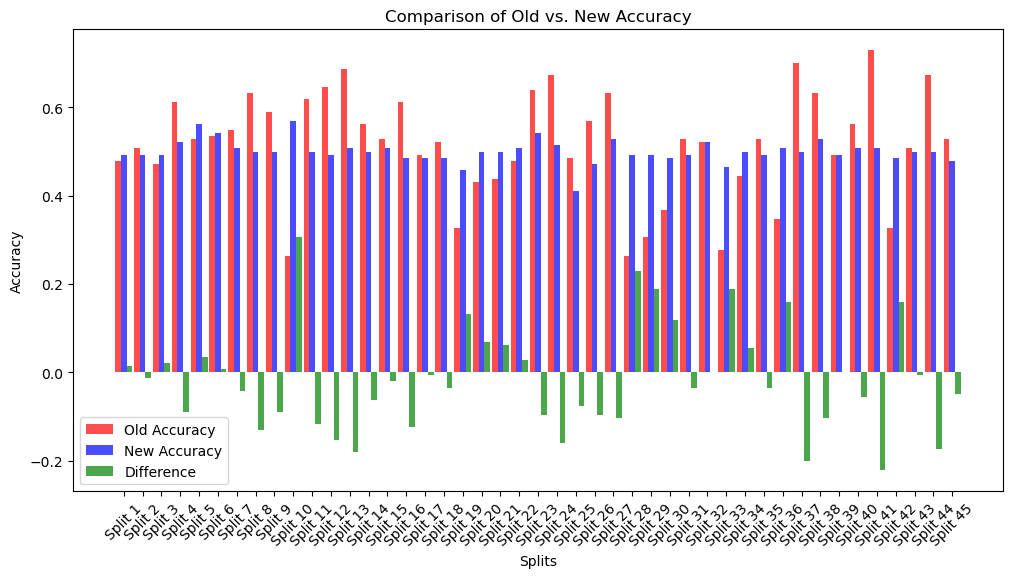

In [110]:
import matplotlib.pyplot as plt
import numpy as np


# Extract values
diffs = [x[0] for x in results]  # New Accuracy - Old Accuracy
old_acc = [x[1] for x in results]
new_acc = [x[2] for x in results]
x_labels = [f"Split {i+1}" for i in range(len(results))]

# Set bar positions
x = np.arange(len(results))
bar_width = 0.3

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust size for readability
ax.bar(x - bar_width, old_acc, bar_width, label="Old Accuracy", color='red', alpha=0.7)
ax.bar(x, new_acc, bar_width, label="New Accuracy", color='blue', alpha=0.7)
ax.bar(x + bar_width, diffs, bar_width, label="Difference", color='green', alpha=0.7)

# Formatting
ax.set_xlabel("Splits")
ax.set_ylabel("Accuracy")
ax.set_title("Comparison of Old vs. New Accuracy")
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45)  # Rotate labels for better readability
ax.legend()

plt.show()


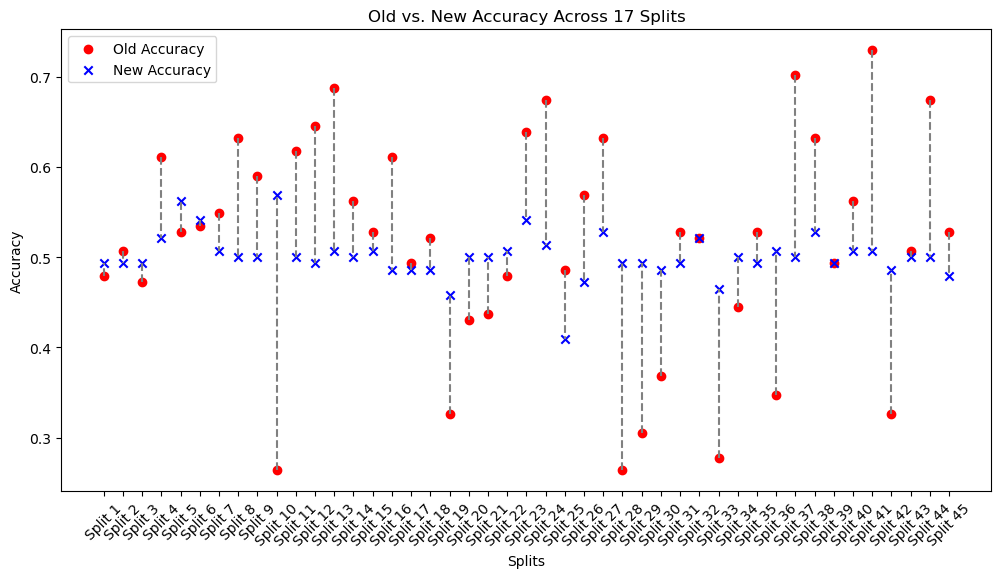

In [113]:
plt.figure(figsize=(12, 6))

plt.scatter(range(len(old_acc)), old_acc, color='red', label='Old Accuracy', marker='o')
plt.scatter(range(len(new_acc)), new_acc, color='blue', label='New Accuracy', marker='x')

# Connect points with a dashed line to show change
for i, (old, new) in enumerate(zip(old_acc, new_acc)):
    plt.plot([i, i], [old, new], color='gray', linestyle='dashed')

# Labels
plt.xlabel("Splits")
plt.ylabel("Accuracy")
plt.xticks(range(len(results)), [f"Split {i+1}" for i in range(len(results))], rotation=45)
plt.legend()
plt.title("Old vs. New Accuracy Across 17 Splits")

plt.show()

In [75]:
diffs = np.array(diffs)
print(diffs.mean())

old_acc = np.array(old_acc)
print(old_acc.mean())
 
new_acc = np.array(new_acc)
print(new_acc.mean())




-0.01589506172839507
0.5165123456790123
0.5006172839506172


In [ ]:
model.save('eeg_ppo_bca_4_2a')